# CS156 Assignment 3

## Assignment instructions:

### Yosemite Village yearly weather
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

Using the temperature dataset from your pre-class work (https://course-resources.minerva.kgi.edu/uploaded_files/mke/rj3Edn/yosemite-temperatures.zip) perform the following:
1. Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.
2. Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.
3. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.
4. (Optional) Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!
5. Using R², quantify how your model performs on the testing data if you:
    1. Train with just the daily component of the model
    2. Train with just the yearly component of the model
    3. Train with the full model.

Please convert everything to a single PDF file and submit it. Be sure to include all the code necessary to reproduce your results, but please leave out exploratory code that does not contribute to any figures or final results. This assignment is not just about code, and any choices which need justification, or insights you gain should be included in plain English.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics



## Data Preprocessing

In [2]:
%%time

years = range(2011, 2017)
files = ['yosemite-data/CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8]
# UTC_DATE: YYYYMMDD 
# UTC_TIME: HHmm 
# Air Temperature: Celcius 

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

cols = ['date','time', 'temp']

df = pd.DataFrame(data, columns=cols)


CPU times: user 3.78 s, sys: 105 ms, total: 3.88 s
Wall time: 3.91 s


In [3]:
# Fixing time formats
df['date'] = df['date'].astype('int64')
df['time'] = df['time'].astype('float64')

df['date'] = df['date'].astype(str)

df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

# Getting hour of day 
df['HoD'] = np.floor_divide(df['time'],100) * 60 + np.mod(df['time'], 100)

# Get valid temperature 
df.drop(df[df.temp < -1000].index, inplace = True)


,date,time,temp,HoD
0,2011-01-01,5.0,-6.4,5.0
1,2011-01-01,10.0,-6.5,10.0
2,2011-01-01,15.0,-6.5,15.0
3,2011-01-01,20.0,-6.5,20.0
4,2011-01-01,25.0,-6.7,25.0


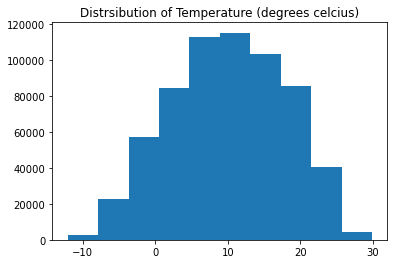

In [4]:
display(df.head(n=5))

plt.hist(df.temp)
plt.title("Distrsibution of Temperature (degrees celcius)")
plt.show()

In [5]:
# %%time 
# Getting day of year

def get_dt_conversion(df):
    DoY = []
    
    period_days = [pd.Period(i, freq = 'H') for i in df['date']]
    
    for i in range(len(period_days)):
        DoY.append(period_days[i].day_of_year)
        
        
    return DoY

df['DoY'] = get_dt_conversion(df)



In [6]:
display(df.head(n=5))
print(df.shape)

,date,time,temp,HoD,DoY
0,2011-01-01,5.0,-6.4,5.0,1
1,2011-01-01,10.0,-6.5,10.0,1
2,2011-01-01,15.0,-6.5,15.0,1
3,2011-01-01,20.0,-6.5,20.0,1
4,2011-01-01,25.0,-6.7,25.0,1


(630854, 5)


CPU times: user 244 ms, sys: 20.4 ms, total: 264 ms
Wall time: 264 ms


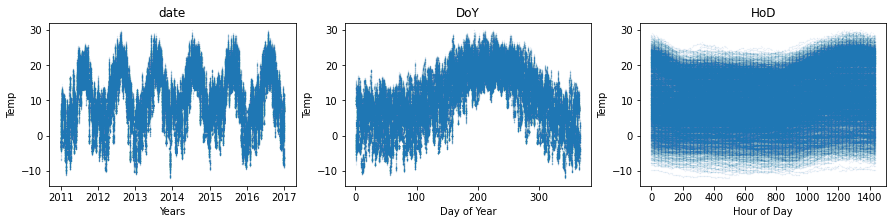

In [7]:
%%time

fig, axs = plt.subplots(1,3, figsize = [15,3])
cols = ['date', 'DoY', 'HoD']
labels = ['Years', 'Day of Year', 'Hour of Day']

for i in range(len(axs)):
    axs[i].scatter(df[cols[i]], df['temp'], alpha = 0.1, s = 0.1)
    axs[i].set_title(cols[i])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel("Temp")

## Linear Parameter Model: RBF

In [8]:
# Getting training and testing data sets 
# Splitting data from training to testing
# Training <= 2015, Testing > 2015

training = df[df['date'].dt.year <= 2015]

X_train = training.drop(columns = ['temp'])
y_train = training['temp']


testing = df[df['date'].dt.year > 2015]
X_test = testing.drop(columns = ['temp'])
y_test = testing['temp']



In [9]:
# Parameters 
sigma = 100
alpha = 0.01

def RBF(x_data, y_data, sigma, alpha):
    # Reshaping 
    x_data = x_data.astype('float64')
    x_data = np.array(x_data)
    x_data = x_data.reshape(-1,1)

    # Getting our RBF Kernels 
    centers = np.linspace(x_data.min(), x_data.max(), 100).reshape(-1,1)
    x_kernel = rbf_kernel(x_data, centers, gamma = 1/sigma)  

    # Fitting the linear model 
    regr = Ridge(alpha = alpha, fit_intercept = False)
    regr.fit(x_kernel, y_data)
    r_squared = regr.score(x_kernel, y_data)
    
    print("Fitting COMPLETE")
    print("Regression Score:", r_squared)
    
    # New representation: 
    all_x = np.linspace(x_data.min(), x_data.max(), len(y_data)).reshape(-1, 1)
    expanded_x = rbf_kernel(all_x, centers, gamma=1.0 / sigma)
    all_y = regr.predict(expanded_x)
    
    print("Prediction COMPLETE")

    return [x_data, y_data, all_x, all_y]


In [10]:
%%time 

# Hour of Day plotting data 
HoD_data = RBF(X_train['HoD'], y_train, sigma, alpha)

# Day of Year plotting data c
DoY_data = RBF(X_train['DoY'], y_train, sigma, alpha)

# Entire data 
x_train = X_train['date']
x_test = X_test['date']

x_train = (x_train - x_train.min())  / np.timedelta64(1,'D')
x_test = (x_test - x_test.min())  / np.timedelta64(1,'D')

date_data = RBF(x_train, y_train, sigma, alpha)


Fitting COMPLETE
Regression Score: 0.04422655338847381
Prediction COMPLETE
Fitting COMPLETE
Regression Score: 0.5982099490568502
Prediction COMPLETE
Fitting COMPLETE
Regression Score: 0.6559643757083855
Prediction COMPLETE
CPU times: user 14.7 s, sys: 2.44 s, total: 17.2 s
Wall time: 7.43 s


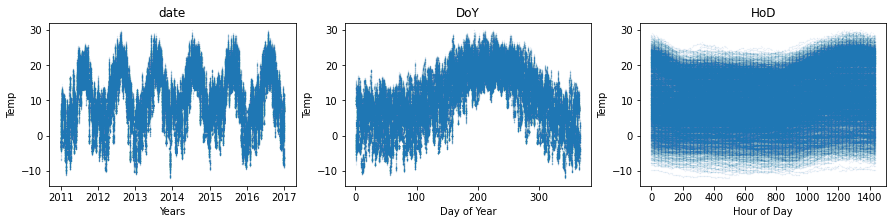

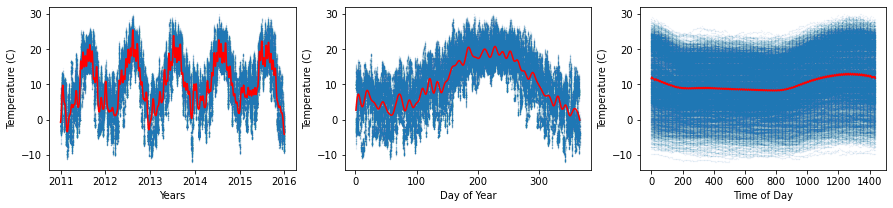

In [11]:

fig, axs = plt.subplots(1,3, figsize = [15,3])
cols = ['date', 'DoY', 'HoD']
labels = ['Years', 'Day of Year', 'Hour of Day']

for i in range(len(axs)):
    axs[i].scatter(df[cols[i]], df['temp'], alpha = 0.1, s = 0.1)
    axs[i].set_title(cols[i])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel("Temp")
    
plt.show()

fig, axs = plt.subplots(1,3, figsize = [15,3])

axs[0].scatter(X_train['date'], date_data[1], label='Data', alpha = 0.1, s = 0.1, c = '#1f77b4') 
axs[0].plot(X_train['date'], date_data[3], label='Linear prediction', color='r')
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Temperature (C)")

axs[1].scatter(DoY_data[0], DoY_data[1], label='Data', alpha = 0.1, s = 0.1, c = '#1f77b4') 
axs[1].plot(DoY_data[2], DoY_data[3], label='Linear prediction', color='r')
axs[1].set_xlabel("Day of Year")
axs[1].set_ylabel("Temperature (C)")

axs[2].scatter(HoD_data[0], HoD_data[1], label='Data', alpha = 0.1, s = 0.1, c = '#1f77b4') 
axs[2].plot(HoD_data[2], HoD_data[3], label='Linear prediction', color='r')
axs[2].set_xlabel("Time of Day")
axs[2].set_ylabel("Temperature (C)")


plt.show()



## Applying model to Testing Data 

To see the relationship of the alpha and sigma values, I tried scaling them togethere and input them in the model. It showed that the higher the alpha and sigma values, the better the r-squared score. 

The sigma value affects the RBF kernel. The higher the sigma value, the less difference distance between points are acquired. Thus, higher sigma values makes it more lenient for the RBF kernel to determine between points. In this model, higher sigma values improves it since we have a lot of noise in the data set and have a high sigma value makes it harder for the model to adapt to the noise. For the alpha value, it is the parameter for our Riddge regression where higher alpha values lead to more robust model but higher risk to overfitting. We can see in our last figure where we fit the entire data set to the model, the testing score deviates from the training score as we increase the alpha values. 


Also, as we fit the data from daily to seasonal, our r-squared score also increases. Apparently, our model does not perform well for daily variations with an almost 0 R-squared score. Our model does perform well for the seasonal variation and it can be shown on the final R-squared scores. 

In [12]:
def acquire_RBF_score(x_train, x_test, y_train, y_test, alpha, sigma):

    # Reshaping 
    x_train = x_train.astype('float64')
    x_test = x_test.astype('float64')

    x_train = np.array(x_train)
    x_test = np.array(x_test)

    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)


    # Getting our RBF Kernels 
    centers = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1,1)

    x = rbf_kernel(x_train, centers, gamma = 1/sigma)  

    # Now go and fit a linear model between x and height
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(x, y_train)
#     print("Score on training data = ", regr.score(x, y_train))
#     print("---TESTING---")
    x_test_kernel = rbf_kernel(x_test, centers, gamma = 1/sigma)

    y_pred = regr.predict(x_test_kernel)
    
    r_squared_training = regr.score(x, y_train)
    r_squared_testing = regr.score(x_test_kernel, y_test)
#     print("Score on training data = ", regr.score(x_test_kernel, y_test))
    
    return r_squared_training, r_squared_testing 



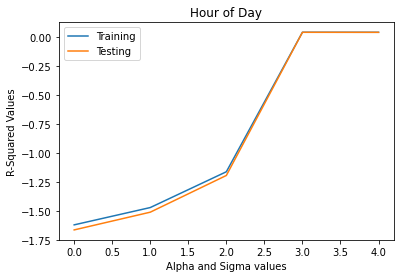

In [13]:
alpha_vals = [0.001, 0.1, 1, 100, 1000]
sigma_vals = [0.001, 0.1, 1, 100, 1000]

x_train = X_train['HoD']
x_test = X_test['HoD']

HoD_R2_train = []
HoD_R2_test = []

for i in range(len(alpha_vals)):
    r_train, r_test = acquire_RBF_score(x_train, x_test, y_train, y_test, alpha_vals[i], sigma_vals[i])
    
    HoD_R2_train.append(r_train)
    HoD_R2_test.append(r_test)

plt.plot(HoD_R2_train, label = 'Training')
plt.plot(HoD_R2_test, label = "Testing")
plt.title("Hour of Day")
plt.legend()
plt.ylabel("R-Squared Values")
plt.xlabel("Alpha and Sigma values")
plt.show()

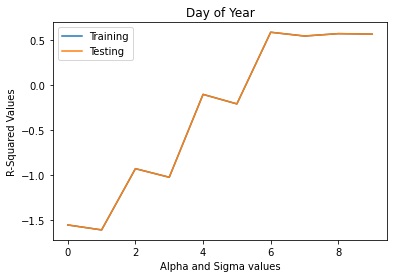

In [14]:
x_train = X_train['DoY']
x_test = X_test['DoY']

DoY_R2_train = []
DoY_R2_test = []

for i in range(len(alpha_vals)):
    r_train, r_test = acquire_RBF_score(x_train, x_test, y_train, y_test, alpha_vals[i], sigma_vals[i])
    
    DoY_R2_train.append(r_train)
    DoY_R2_train.append(r_test)
    
plt.plot(DoY_R2_train, label = 'Training')
plt.plot(DoY_R2_train, label = "Testing")
plt.title("Day of Year")
plt.legend()
plt.ylabel("R-Squared Values")
plt.xlabel("Alpha and Sigma values")
plt.show()

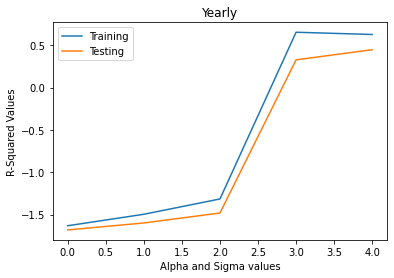

In [15]:
x_train = X_train['date']
x_test = X_test['date']

x_train = (x_train - x_train.min())  / np.timedelta64(1,'D')
x_test = (x_test - x_test.min())  / np.timedelta64(1,'D')

# Reshaping 
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')

x_train = np.array(x_train)
x_test = np.array(x_test)

date_R2 = []

date_R2_train = []
date_R2_test = []

for i in range(len(alpha_vals)):
    r_train, r_test = acquire_RBF_score(x_train, x_test, y_train, y_test, alpha_vals[i], sigma_vals[i])
    
    date_R2_train.append(r_train)
    date_R2_test.append(r_test)
    
plt.plot(date_R2_train, label = 'Training')
plt.plot(date_R2_test, label = "Testing")
plt.title("Yearly")
plt.legend()
plt.ylabel("R-Squared Values")
plt.xlabel("Alpha and Sigma values")
plt.show()